In [1]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [2]:
# Hyperparameters
batch_size=64
learning_rate=1e-7


# Other constants
DATASET_URL = "https://raw.githubusercontent.com/thenu97/loan_prediction_dataset/master/datasets_172655_390726_test.csv"
DATA_FILENAME = "datasets_172655_390726_test.csv"
TARGET_COLUMN = 'LoanAmount'
input_size=10
output_size=1

In [3]:
download_url(DATASET_URL, '.')
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()

Using downloaded and verified file: ./datasets_172655_390726_test.csv


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [4]:
cat_f = dataframe.select_dtypes(include='object')
categorical_cols = list(cat_f.columns.values.tolist())
categorical_cols

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area']

In [5]:
input_col = list(dataframe.columns)[1:8] + list(dataframe.columns)[9:]
input_col

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area']

In [6]:
output_col = ['LoanAmount']

In [7]:
# Convert from Pandas dataframe to numpy arrays
dataframe1 = dataframe.copy(deep=True).dropna()
for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
inputs_array = dataframe1.drop(['Loan_ID', 'LoanAmount' ], axis=1)
targets_array = dataframe1[['LoanAmount']].values
mean = inputs_array.mean()
dev = inputs_array.std()
inputs_array = (inputs_array - mean) / dev
inputs_array = inputs_array.values
inputs_array.shape, targets_array.shape

((289, 10), (289, 1))

In [8]:
num_rows = dataframe1.shape[0]
print(num_rows)

289


In [10]:
inputs = torch.from_numpy(inputs_array).float() 
targets = torch.from_numpy(targets_array).float()

In [11]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [12]:
inputs.size(), targets.size()

(torch.Size([289, 10]), torch.Size([289, 1]))

In [13]:
dataset = TensorDataset(inputs, targets)

In [14]:
val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length
len(train_ds), len(val_ds)

(246, 43)

In [15]:
batch_size = 10

In [16]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
print(len(train_ds), len(val_ds))

246 43


In [17]:
print(len(input_col))

10


## Step 3: Create a Linear Regression Model
Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment).

In [18]:
input_size, output_size

(10, 1)

In [19]:
class LoanModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10, 1)                  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                        # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                        # fill this
        return {'val_loss': loss}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [20]:
model = LoanModel()
model

LoanModel(
  (linear): Linear(in_features=10, out_features=1, bias=True)
)

In [21]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0594,  0.1133, -0.1443, -0.3092, -0.2069, -0.0493, -0.1377,  0.1554,
           0.0246, -0.0860]], requires_grad=True), Parameter containing:
 tensor([-0.1064], requires_grad=True)]

## Step 4: Train the model to fit the data
To train our model, we'll use the same fit function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [22]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [23]:
result = evaluate(model, val_loader) # Use the the evaluate function
result

{'val_loss': 128.74240112304688}

In [24]:
epochs = 25
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 123.8331
Epoch [25], val_loss: 122.6050


In [25]:
epochs = 47
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 122.1144
Epoch [40], val_loss: 121.6233
Epoch [47], val_loss: 121.4517


In [26]:
epochs = 103
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 121.4026
Epoch [40], val_loss: 121.3535
Epoch [60], val_loss: 121.3044
Epoch [80], val_loss: 121.2553
Epoch [100], val_loss: 121.2061
Epoch [103], val_loss: 121.1987


In [27]:
epochs = 229
lr = 1e-10
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 121.1987
Epoch [40], val_loss: 121.1987
Epoch [60], val_loss: 121.1987
Epoch [80], val_loss: 121.1987
Epoch [100], val_loss: 121.1987
Epoch [120], val_loss: 121.1987
Epoch [140], val_loss: 121.1987
Epoch [160], val_loss: 121.1987
Epoch [180], val_loss: 121.1987
Epoch [200], val_loss: 121.1987
Epoch [220], val_loss: 121.1987
Epoch [229], val_loss: 121.1987


In [28]:
epochs = 229
lr = 1e-2
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 116.2924
Epoch [40], val_loss: 111.3852
Epoch [60], val_loss: 106.4836
Epoch [80], val_loss: 101.5797
Epoch [100], val_loss: 96.7355
Epoch [120], val_loss: 92.1295
Epoch [140], val_loss: 87.6566
Epoch [160], val_loss: 83.3435
Epoch [180], val_loss: 79.0939
Epoch [200], val_loss: 75.0900
Epoch [220], val_loss: 71.1719
Epoch [229], val_loss: 69.4337


In [29]:
epochs = 400
lr = 1e-2
history6 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 65.8033
Epoch [40], val_loss: 62.2778
Epoch [60], val_loss: 58.9177
Epoch [80], val_loss: 56.0210
Epoch [100], val_loss: 53.2787
Epoch [120], val_loss: 50.8420
Epoch [140], val_loss: 48.6752
Epoch [160], val_loss: 46.5975
Epoch [180], val_loss: 44.7512
Epoch [200], val_loss: 43.1659
Epoch [220], val_loss: 41.7201
Epoch [240], val_loss: 40.4572
Epoch [260], val_loss: 39.3363
Epoch [280], val_loss: 38.3780
Epoch [300], val_loss: 37.6000
Epoch [320], val_loss: 37.0140
Epoch [340], val_loss: 36.4677
Epoch [360], val_loss: 35.9580
Epoch [380], val_loss: 35.5122
Epoch [400], val_loss: 35.1274


In [30]:
epochs = 400
lr = 1e-1
history7 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 33.3980
Epoch [40], val_loss: 33.1849
Epoch [60], val_loss: 32.9085
Epoch [80], val_loss: 32.8428
Epoch [100], val_loss: 32.7548
Epoch [120], val_loss: 32.7235
Epoch [140], val_loss: 32.6775
Epoch [160], val_loss: 32.6586
Epoch [180], val_loss: 32.6990
Epoch [200], val_loss: 32.7894
Epoch [220], val_loss: 32.9315
Epoch [240], val_loss: 33.0118
Epoch [260], val_loss: 33.0633
Epoch [280], val_loss: 33.1795
Epoch [300], val_loss: 33.2053
Epoch [320], val_loss: 33.2019
Epoch [340], val_loss: 33.2012
Epoch [360], val_loss: 33.1693
Epoch [380], val_loss: 33.1785
Epoch [400], val_loss: 33.1953


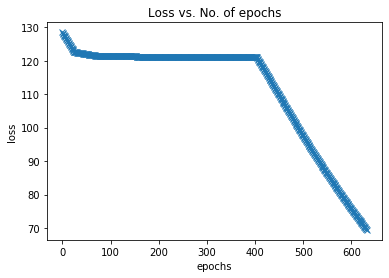

In [31]:
history = history1 + history2 + history3 + history4 + history5
loss = [result['val_loss'] for result in history]
plt.plot(loss, '-x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [32]:
val_loss = 31.1528

## Step 5: Make predictions using the trained model


In [33]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [34]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([-1.9710, -1.3517,  1.1257, -0.5377, -0.3523,  0.0690, -0.6428,  0.2639,
         0.4343, -0.0997])
Target: tensor([189.])
Prediction: tensor([118.3028])


In [35]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([ 0.5056,  0.7373,  0.1854, -0.5377, -0.3523, -0.1859,  0.2569,  0.2639,
         0.4343,  1.1003])
Target: tensor([125.])
Prediction: tensor([131.9366])


In [36]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([ 0.5056, -1.3517, -0.7548, -0.5377, -0.3523,  0.0721, -0.6428,  0.2639,
         0.4343,  1.1003])
Target: tensor([141.])
Prediction: tensor([115.2977])
